In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
np.set_printoptions(precision=2, linewidth=120)
from copy import copy
from tqdm import *
from drift_qec.Q import *

/Users/yan/.miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Regime 1 basis alignment

In [28]:
pyhat

array([-0.47,  0.43, -0.77])

In [27]:
D * np.min([pyhat, pzhat]) / np.abs(pyhat-pzhat)

array([ 0.31,  0.38,  1.33])

In [29]:
D = 0.01*np.pi
N_TRIALS = 100
MAX_N = int(1e6)
N_STEP = int(1e3)
RECORDS = []
for trial in tqdm(range(N_TRIALS)):
    channel = Channel(kx=0.7, ky=0.2, kz=0.1,
                      Q=np.linalg.qr(np.random.randn(3,3))[0],
                      n=N_STEP, d1=D, d2=D, d3=D)
    pxhat, pyhat, pzhat = list(np.linalg.eig(channel.Mhat)[0])
    RECORDS.append({
            "trial": trial,
            "time": 0,
            "tr": np.trace(channel.Mhat),
            "d1": channel.d1, "d2": channel.d2, "d3": channel.d3,
            "Mdist": np.linalg.norm(channel.Mhat-channel.C),
            "Qdist": np.linalg.norm(np.dot(channel.Qc.T, channel.Q) - np.eye(3)),
            "pxval": channel.kx, "pyval": channel.ky, "pzval": channel.kz,
            "pxhat": pxhat, "pyhat": pyhat, "pzhat": pzhat
        })
    for time in range(0, MAX_N, N_STEP):
        channel.update()
        pxhat, pyhat, pzhat = list(np.linalg.eig(channel.Mhat)[0])
        channel.d1 = D * np.min([pxhat, pyhat]) / np.sqrt(np.abs(pxhat-pyhat))
        channel.d2 = D * np.min([pxhat, pzhat]) / np.sqrt(np.abs(pxhat-pzhat))
        channel.d3 = D * np.min([pyhat, pzhat]) / np.sqrt(np.abs(pyhat-pzhat))
        RECORDS.append({
                "trial": trial,
                "time": time,
                "tr": np.trace(channel.Mhat),
                "d1": channel.d1, "d2": channel.d2, "d3": channel.d3,
                "Mdist": np.linalg.norm(channel.Mhat-channel.C),
                "Qdist": np.linalg.norm(np.dot(channel.Qc.T, channel.Q) - np.eye(3)),
                "pxval": channel.kx, "pyval": channel.ky, "pzval": channel.kz,
                "pxhat": pxhat, "pyhat": pyhat, "pzhat": pzhat
            })

df = pd.DataFrame(RECORDS)
df.to_csv("regime1_adaptive_delta.csv")

In [30]:
D = 0.25*np.pi
N_TRIALS = 100
MAX_N = int(1e6)
N_STEP = int(1e3)
RECORDS = []
for trial in tqdm(range(N_TRIALS)):
    channel = Channel(kx=0.985, ky=0.01, kz=0.005,
                      Q=np.linalg.qr(np.random.randn(3,3))[0],
                      n=N_STEP, d1=D, d2=D, d3=D)
    pxhat, pyhat, pzhat = list(np.linalg.eig(channel.Mhat)[0])
    RECORDS.append({
            "trial": trial,
            "time": 0,
            "tr": np.trace(channel.Mhat),
            "d1": channel.d1, "d2": channel.d2, "d3": channel.d3,
            "Mdist": np.linalg.norm(channel.Mhat-channel.C),
            "Qdist": np.linalg.norm(np.dot(channel.Qc.T, channel.Q) - np.eye(3)),
            "pxval": channel.kx, "pyval": channel.ky, "pzval": channel.kz,
            "pxhat": pxhat, "pyhat": pyhat, "pzhat": pzhat
        })
    for time in range(0, MAX_N, N_STEP):
        channel.update()
        pxhat, pyhat, pzhat = list(np.linalg.eig(channel.Mhat)[0])
        channel.d1 = D * np.min([pxhat, pyhat]) / np.sqrt(np.abs(pxhat-pyhat))
        channel.d2 = D * np.min([pxhat, pzhat]) / np.sqrt(np.abs(pxhat-pzhat))
        channel.d3 = D * np.min([pyhat, pzhat]) / np.sqrt(np.abs(pyhat-pzhat))
        RECORDS.append({
                "trial": trial,
                "time": time,
                "tr": np.trace(channel.Mhat),
                "d1": channel.d1, "d2": channel.d2, "d3": channel.d3,
                "Mdist": np.linalg.norm(channel.Mhat-channel.C),
                "Qdist": np.linalg.norm(np.dot(channel.Qc.T, channel.Q) - np.eye(3)),
                "pxval": channel.kx, "pyval": channel.ky, "pzval": channel.kz,
                "pxhat": pxhat, "pyhat": pyhat, "pzhat": pzhat
            })

df = pd.DataFrame(RECORDS)
df.to_csv("regime2_adaptive_delta.csv")

In [31]:
df1 = pd.read_csv("regime1_adaptive_delta.csv")
v1 = df1.groupby("time").mean()
s1 = df1.groupby("time").std()

df2 = pd.read_csv("regime2_adaptive_delta.csv")
v2 = df2.groupby("time").mean()
s2 = df2.groupby("time").std()

In [33]:
v1

,Unnamed: 0,Mdist,Qdist,d1,d2,d3,pxhat,pxval,pyhat,pyval,pzhat,pzval,tr,trial
time,,,,,,,,,,,,,,
0,49550.0,0.516159,2.257714,0.016510,0.016215,0.023152,0.340449,0.7,0.334405,0.2,0.325147,0.1,1,49.5
1000,49551.5,6.188580,2.265973,-0.018676,-0.028688,-0.009270,-0.916758,0.7,1.134819,0.2,0.781939,0.1,1,49.5
2000,49552.5,5.796092,2.213086,-0.020502,-0.030820,-0.009750,-0.783122,0.7,1.287996,0.2,0.495126,0.1,1,49.5
3000,49553.5,4.858932,2.307373,-0.017796,-0.027874,-0.008269,-0.435992,0.7,1.055221,0.2,0.380771,0.1,1,49.5
4000,49554.5,5.369329,2.237171,-0.021503,-0.029041,-0.005199,-0.476243,0.7,0.745006,0.2,0.731237,0.1,1,49.5
5000,49555.5,4.892875,2.307868,-0.019800,-0.026034,-0.005860,-0.076840,0.7,0.451972,0.2,0.624867,0.1,1,49.5
6000,49556.5,4.416085,2.221683,-0.018700,-0.024715,-0.003901,-0.102988,0.7,0.559016,0.2,0.543973,0.1,1,49.5
7000,49557.5,3.965111,2.207747,-0.016367,-0.023371,-0.002468,-0.058923,0.7,0.558552,0.2,0.500372,0.1,1,49.5
8000,49558.5,5.051334,2.214610,-0.018139,-0.023333,-0.003078,0.658657,0.7,-0.186173,0.2,0.527516,0.1,1,49.5


IndexError: index 3 is out of bounds for axis 1 with size 3

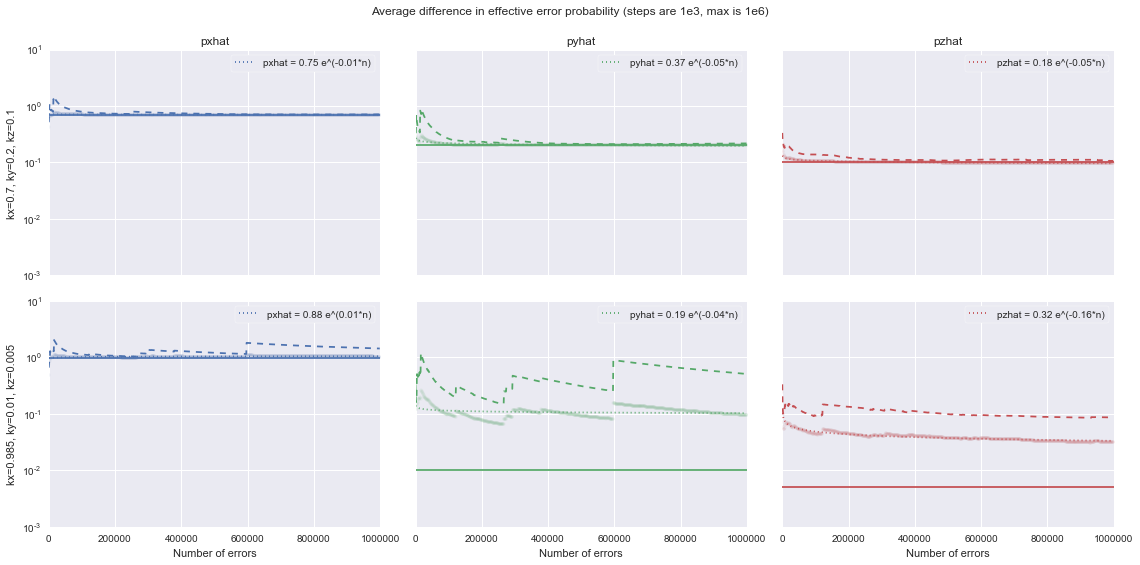

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(16, 8), sharey=True, sharex=True,
                        tight_layout={"h_pad": 1.0, "rect": [0.0, 0.0, 1.0, 0.95]})

for idx, stat in enumerate(["pxhat", "pyhat", "pzhat"]):
    t1 = v1[stat].index.values
    y1 = v1[stat].values
    e1 = s1[stat].values
    x = np.log(v1.loc[1:, stat].index.values)
    y = np.log(v1.loc[1:, stat].values)
    reg = sp.stats.linregress(x, y)
    fitted = np.exp(reg.intercept + reg.slope * x)
    axs[0, idx].semilogy(t1, y1, ls="", marker=".", color=sns.color_palette()[idx], alpha=0.05)
    axs[0, idx].semilogy(t1, y1+e1, ls="--", color=sns.color_palette()[idx])
    axs[0, idx].semilogy(t1[1:], fitted, ls=":", color=sns.color_palette()[idx],
                         label="{} = {:0.2f} e^({:0.2f}*n)".format(stat, np.exp(reg.intercept), reg.slope))
    axs[0, idx].axhline(df1.loc[0, stat[:2]+"val"], color=sns.color_palette()[idx])
    axs[0, idx].set_title(stat)
    axs[0, idx].legend(frameon=True)
    
    t2 = v2[stat].index.values
    y2 = v2[stat].values
    e2 = s2[stat].values
    x = np.log(v2.loc[1:, stat].index.values)
    y = np.log(v2.loc[1:, stat].values)
    reg = sp.stats.linregress(x, y)
    fitted = np.exp(reg.intercept + reg.slope * x)
    axs[1, idx].semilogy(t2, y2, ls="", marker=".", color=sns.color_palette()[idx], alpha=0.05)
    axs[1, idx].semilogy(t2, y2+e2, ls="--", color=sns.color_palette()[idx])
    axs[1, idx].semilogy(t2[1:], fitted, ls=":", color=sns.color_palette()[idx],
                         label="{} = {:0.2f} e^({:0.2f}*n)".format(stat, np.exp(reg.intercept), reg.slope))
    axs[1, idx].axhline(df2.loc[0, stat[:2]+"val"], color=sns.color_palette()[idx])
    axs[1, idx].set_xlabel("Number of errors")
    axs[1, idx].legend(frameon=True)

fig.suptitle("Average difference in effective error probability (steps are 1e3, max is 1e6)")
axs[0, 0].set_ylabel("kx=0.7, ky=0.2, kz=0.1")
axs[1, 0].set_ylabel("kx=0.985, ky=0.01, kz=0.005")

axs[0, 3].semilogy(v1["d"].index.values, v1["d"].values, color=sns.color_palette()[3])
axs[1, 3].semilogy(v2["d"].index.values, v2["d"].values, color=sns.color_palette()[3])

axs[1, 0].set_ylim([0.001, 1.0])
axs[0, 0].set_ylim([0.001, 1.0])
fig.savefig("adaptivedelta_1e3_1e6.pdf")